# Reduction and calibration script for long-slit spectra

In [1]:
__main__ = 'Manual_reduction_spectra'
__author__ = 'Pascal Louis <plouis35@gmail.com>'
__version__ = '0.1'
__keywords__ = ['astronomy', 'spectroscopy', 'astropy', 'specutils', 'specreduce', 'matplotlib']
import sys, numpy, matplotlib
print('Python ' + sys.version)
print('matplotlib ' + str(sys.modules['matplotlib'].__version__))
print('numpy ' + str(sys.modules['numpy'].__version__))
#!jupyter --version


Python 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:09:20) [Clang 16.0.6 ]
matplotlib 3.8.3
numpy 1.26.4


## Configuration

In [2]:
#dir = 'e:/Astro/Captures/20231008_Void/'
dir = '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/'
#dir = 'E:/Astro/Captures/20161006_tp_spectro_L3/'

#bias = 'Bias*.fit'
bias = 'offset-*.fit'
#darks = 'dark*.fit'
darks = 'noir-600-*.fit'
flats = 'flat*.fit'
calibs = 'neon-*.fit'

sciences = 'hd158460-*.fit'
sciencedata = 'hd158460.fit'
#sciences = 'ngc6543-*.fit'
#sciencedata = 'ngc6543.fit'
#sciences = 'deneb*.fit'
#sciencedata = 'deneb.fit'

trim_region = '600, 600, 2700, 1400'              # x1, y1, x2, y2 
#trim_region = None

masterbias = 'masterbias.fit'
masterdark = 'masterdark.fit'
masterflat = 'masterflat.fit'
mastercalib = 'mastercalib.fit'

overwrite_masters = False         # recreate masters or not ?
memory_limit = 1e9               # how much memory (bytes) to allocate to combine operations ?

#camera_electronic_gain = 1.2     # asi 183mm
#camera_readout_noise = 2.2       # asi 183mm

#camera_electronic_gain = 0.13    # atik 420m 
#camera_readout_noise = 3.0       # atik 420m

camera_electronic_gain = 0.27    # atik 460m 
camera_readout_noise = 5.0       # atik 460m

## Imports libs

In [3]:
%matplotlib widget
import warnings, fnmatch, os
from time import gmtime, strftime
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, QTable
from astropy import units as u
from astropy.nddata import CCDData, StdDevUncertainty
from astropy.stats import mad_std
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning

from ccdproc import Combiner, combine, subtract_bias, subtract_dark, flat_correct
from ccdproc import trim_image, Combiner, ccd_process, cosmicray_median

from align_combine import align_and_combine

#warnings.simplefilter('ignore', category=AstropyWarning)
#warnings.simplefilter('ignore', UserWarning)


## Create logger

In [4]:
import sys
import logging

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')

## Create masters

### Bias

In [5]:
### prepare filenames lists
bias_files = [dir + f for f in fnmatch.filter(os.listdir(dir), bias)]
logger.info('bias files to combine: ' + repr(bias_files))

### create masterbias
bias_list =  []
if (os.path.exists(dir + masterbias)) and (overwrite_masters is False):
    logger.info(masterbias + ' not (re)created')
else:
    #bias_list = [CCDData.read(f, unit = u.adu ) for f in bias_files]
    for bias_file in bias_files:
        logger.info('bias trim {} ...'.format(bias_file))
        _bias_data = CCDData.read(bias_file, unit = u.adu )

        _bias_trim = _bias_data
        if trim_region is not None:
            _bias_trim = trim_image(_bias_data[eval(trim_region)[1]:eval(trim_region)[3], eval(trim_region)[0]:eval(trim_region)[2]]) 

        bias_trim = CCDData(_bias_trim.data.astype('float32'), unit = u.adu , header = _bias_data.header)            
        bias_list.append(bias_trim)
        _bias_data = None

    logger.info('masterbias combine...')
    #_bias_master = combine(bias_list, method = 'median', dtype = np.float32, mem_limit = memory_limit)   
    _bias_master = combine(bias_list,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, dtype = np.float32,
                             mem_limit = memory_limit
                            )

    bias_master = CCDData(_bias_master.data.astype('float32'), unit = u.adu , header = _bias_master.header)

    #logger.info('masterbias nomalization...')
    #bias_master.data = (bias_master.data - 1) / (10 - 1)
    
    bias_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    bias_master.meta['combined'] = True
    bias_master.meta['history'] = 'combined from {} bias file(s)'.format(len(bias_files))
    bias_master.write(dir + masterbias, overwrite=True)
    logger.info('masterbias created - combined from {} bias file(s)'.format(len(bias_files)))
    bias_list = None
    _bias_master = None


2024-02-24 17:14:52 [INFO] - bias files to combine: ['/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/offset-9.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/offset-8.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/offset-6.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/offset-7.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/offset-5.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/offset-4.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/offset-1.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/offset-3.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/offset-2.fit']
2024-02-24 

### Darks

In [6]:
### prepare filenames lists
dark_files = [dir + f for f in fnmatch.filter(os.listdir(dir), darks)]
logger.info('dark files to combine : ' + repr(dark_files))

### create masterdark
darks_list = []
if (os.path.exists(dir + masterdark)) and (overwrite_masters is False):
    logger.info(masterdark + ' not (re)created')
else:
    for dark_file in dark_files:
        _dark_data = CCDData.read(dark_file, unit = u.adu )
        _dark_trim = _dark_data
        if trim_region is not None:
            logger.info('dark trim {} ...'.format(dark_file))
            _dark_trim = trim_image(_dark_data[eval(trim_region)[1]:eval(trim_region)[3], eval(trim_region)[0]:eval(trim_region)[2]]) 

        logger.info('masterbias sub {} ...'.format(dark_file))
        _dark_sub = subtract_bias(_dark_trim, bias_master)
        dark_sub = CCDData(_dark_sub.data.astype('float32'), unit = u.adu , header = _dark_data.header)
        darks_list.append(dark_sub)
        _dark_data = None
        _dark_sub = None
        _dark_trim = None
    
    logger.info('masterdark combine...')
    #dark_master = combine(darks_list, method='median', dtype=np.uint32, mem_limit = memory_limit)
    _dark_master = combine(darks_list,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, dtype=np.float32,
                                 mem_limit=memory_limit
                                )
    
    dark_master = CCDData(_dark_master.data.astype('float32'), unit = u.adu , header = _dark_master.header)
    dark_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    dark_master.meta['combined'] = True
    dark_master.meta['history'] = 'masterbias sub + combined from {} dark file(s)'.format(len(dark_files))
    dark_master.write(dir + masterdark, overwrite=True)
    logger.info('masterdark created - bias substracted + combined from {} dark file(s)'.format(len(dark_files)))
    darks_list = None
    _dark_master = None


2024-02-24 17:14:52 [INFO] - dark files to combine : ['/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/noir-600-3.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/noir-600-2.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/noir-600-1.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/noir-600-5.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/noir-600-4.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/noir-600-6.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/noir-600-7.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/noir-600-9.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/noir-600-

### Flats

In [7]:
### prepare filenames lists
flat_files = [dir + f for f in fnmatch.filter(os.listdir(dir), flats)]
logger.info('flat files to combine: ' + repr(flat_files))

### create masterflat
flats_list = []

def inv_median(a):
    return 1 / np.median(a)
    
if (os.path.exists(dir + masterflat)) and (overwrite_masters is False):
    logger.info(masterflat + ' not (re)created')
else:
    for flat_file in flat_files:
        _flat_data = CCDData.read(flat_file, unit = u.adu )
        _flat_trim = _flat_data
        if trim_region is not None:
            logger.info('flat trim {} ...'.format(flat_file))
            _flat_trim = trim_image(_flat_data[eval(trim_region)[1]:eval(trim_region)[3], eval(trim_region)[0]:eval(trim_region)[2]]) 

        logger.info('masterbias sub {} ...'.format(flat_file))
        _flat_sub = subtract_bias(_flat_trim, bias_master)
        flat_sub = CCDData(_flat_sub.data.astype('float32'), unit = u.adu , header = _flat_data.header)
        flats_list.append(flat_sub)
        _flat_data = None
        _flat_sub = None
        _flat_trim = None
    
    logger.info('masterflat combine...')
    _flat_master = combine(flats_list, method='sum', dtype=np.float32, mem_limit = memory_limit)
    #_flat_master = combine(flats_list,
     #                            method='average', #scale=inv_median,
      #                           sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
       #                          sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, dtype=np.float32,
        #                         mem_limit=memory_limit
         #                       )
    flat_master = CCDData(_flat_master.data.astype('float32'), unit = u.adu , header = _flat_master.header)
    flat_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    flat_master.meta['combined'] = True
    flat_master.meta['history'] = 'bias substracted + combined from {} flat file(s)'.format(len(flat_files))
    flat_master.write(dir + masterflat, overwrite=True)
    logger.info('masterflat created : bias substracted + combined from {} flat file(s)'.format(len(flat_files)))
    flats_list = None
    _flat_master = None


2024-02-24 17:14:52 [INFO] - flat files to combine: ['/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/flat-8.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/flat-9.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/flat-12.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/flat-13.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/flat-11.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/flat-10.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/flat-14.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/flat-15.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/flat-17.fit', '/Users/papa/Documents

### Calibration

In [8]:
calib_files = [dir + f for f in fnmatch.filter(os.listdir(dir), calibs)]
logger.info('calibration files to combine: ' + repr(calib_files))

### create mastercalib
calibs_list = []
   
if (os.path.exists(dir + mastercalib)) and (overwrite_masters is False):
    logger.info(mastercalib + ' not (re)created')
else:
    for calib_file in calib_files:
        _calib_data = CCDData.read(calib_file, unit = u.adu )
        _calib_trim = _calib_data
        if trim_region is not None:
            logger.info('calib trim {} ...'.format(calib_file))
            _calib_trim = trim_image(_calib_data[eval(trim_region)[1]:eval(trim_region)[3], eval(trim_region)[0]:eval(trim_region)[2]]) 
        
        logger.info('masterbias sub {} ...'.format(calib_file))
        _calib_sub = subtract_bias(_calib_trim, bias_master)
        calib_sub = CCDData(_calib_sub.data.astype('float32'), unit = u.adu , header = _calib_data.header)
        calibs_list.append(calib_sub)
        _calib_data = None
        _calib_sub = None
    
    logger.info('mastercalib combine...')
    #calib_master = combine(calib_list, method='median', dtype=np.float32, mem_limit = memory_limit)
    _calib_master = combine(calibs_list,
                                 method='average', 
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, dtype=np.float32,
                                 mem_limit=memory_limit
                                )
    calib_master = CCDData(_calib_master.data.astype('float32'), unit = u.adu , header = _calib_master.header)
    calib_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    calib_master.meta['combined'] = True
    calib_master.meta['history'] = 'bias substracted + combined from {} calib file(s)'.format(len(calib_files))
    calib_master.write(dir + mastercalib, overwrite=True)
    logger.info('mastercalib created : bias substracted + combined from {} calib file(s)'.format(len(calib_files)))
    calib_list = None
    _calib_master = None


2024-02-24 17:14:52 [INFO] - calibration files to combine: ['/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/neon-2.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/neon-1.fit']
2024-02-24 17:14:52 [INFO] - mastercalib.fit not (re)created


## Process science files

### Reduce

In [9]:
### prepare filenames lists
science_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), sciences)]
logger.info('science files : ' + repr(science_files))

if overwrite_masters is False:
    bias_master = CCDData.read(dir + masterbias, unit = u.adu )
    dark_master = CCDData.read(dir + masterdark, unit = u.adu )
    flat_master = CCDData.read(dir + masterflat, unit = u.adu )

"""
### process science files - individual science file process version
for sci_file in science_files:
    logger.info('masterbias sub {} ...'.format(sci_file))
    #sci_data = CCDData.read(sci_file, unit = u.adu )
    sci_sub_bias = subtract_bias(CCDData.read(sci_file, unit = u.adu ), bias_master)
    #sci_data = None
    logger.info('masterdark sub {} ...'.format(sci_file))
    sci_sub_dark = subtract_dark(sci_sub_bias, dark_master, scale = True, exposure_time='EXPTIME', exposure_unit=u.second)
    sci_sub_bias = None
    logger.info('masterflat divide {} ...'.format(sci_file))
    sci_div_flat = flat_correct(sci_sub_dark, flat_master)
    sci_sub_dark = None
    sci_ok = CCDData(sci_div_flat.data.astype('float32'), unit = u.adu , header = sci_div_flat.header)
    sci_div_flat = None
    logger.info('writing science file (-ppr) {}'.format(sci_file))
    sci_ok.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    sci_ok.meta['history'] = 'bias substracted + dark substrated + flat divide'
    sci_ok.write(Path(sci_file).with_stem(f"{'ppr'}-{Path(sci_file).stem}"), overwrite=True)
"""

### process science files - ccd_process version
for sci_file in science_files:
    sci_data = CCDData.read(sci_file, unit = u.adu )
    _sci_trim = sci_data
    if trim_region is not None:
        logger.info('science trim {} ...'.format(sci_file))
        _sci_trim = trim_image(sci_data[eval(trim_region)[1]:eval(trim_region)[3], eval(trim_region)[0]:eval(trim_region)[2]]) 
    
    logger.info('processing (masterbias sub + masterdark sub + masterflat divide) {} ...'.format(sci_file))
    sci_data_processed = ccd_process(_sci_trim, 
            oscan = None, 
            gain_corrected = False, 
            trim = None, 
            error = False,
            gain = camera_electronic_gain*u.electron/u.adu ,
            readnoise = camera_readout_noise*u.electron,
            master_bias = bias_master,
            dark_frame = dark_master,
            master_flat = flat_master,
            exposure_key = 'EXPTIME',
            exposure_unit = u.second,
            dark_scale = True)
    sci_ok = CCDData(sci_data_processed.data.astype('float32'), unit = u.adu , header = sci_data.header)
    sci_data = None
    logger.info('writing science datafile (-ppr) {}'.format(sci_file))
    sci_ok.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    sci_ok.meta['history'] = 'bias substracted + dark substrated + flat divide'
    sci_ok.write(Path(sci_file).with_stem(f"{'ppr'}-{Path(sci_file).stem}"), overwrite=True)


2024-02-24 17:14:52 [INFO] - science files : ['/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-4.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-5.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-2.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-3.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-1.fit']
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:52 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-02-24 17:14:52 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57480.567940 from DATE-OBS'.
INFO: using the unit adu passed to the FITS reader instead of the unit

2024-02-24 17:14:53 [INFO] - writing science datafile (-ppr) /Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-4.fit
2024-02-24 17:14:53 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57667.794028 from DATE-OBS'.
2024-02-24 17:14:53 [INFO] - science trim /Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-5.fit ...
2024-02-24 17:14:53 [INFO] - processing (masterbias sub + masterdark sub + masterflat divide) /Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-5.fit ...
2024-02-24 17:14:53 [INFO] - writing science datafile (-ppr) /Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-5.fit
2024-02-24 17:14:53 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57667.789549 from DATE-OBS'.
2024-02-24 17:14:53 [INFO] - science trim /Users/papa/Documents/ASTRO/CAPTURES/202

2024-02-24 17:14:53 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57667.791042 from DATE-OBS'.
2024-02-24 17:14:53 [INFO] - science trim /Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-3.fit ...
2024-02-24 17:14:53 [INFO] - processing (masterbias sub + masterdark sub + masterflat divide) /Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-3.fit ...
2024-02-24 17:14:53 [INFO] - writing science datafile (-ppr) /Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-3.fit
2024-02-24 17:14:53 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57667.788056 from DATE-OBS'.
2024-02-24 17:14:53 [INFO] - science trim /Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/hd158460-1.fit ...
2024-02-24 17:14:53 [INFO] - processing (masterbias sub + masterdark sub + masterflat divide) /Us

### Align and combine

In [10]:
if overwrite_masters is False:
    bias_master = CCDData.read(dir + masterbias, unit = u.adu )
    dark_master = CCDData.read(dir + masterdark, unit = u.adu )
    flat_master = CCDData.read(dir + masterflat, unit = u.adu )

### align images and combine using a SUM
science_files_ppr  = [dir + f for f in fnmatch.filter(os.listdir(dir), 'ppr-' + sciences)]
logger.info('science files aligning and combining ... : ' + repr(science_files_ppr))
sci_aligned = align_and_combine(science_files_ppr, np.sum)
sci_master = CCDData(sci_aligned, unit = u.adu , header = sci_ok.header)
sci_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
sci_master.meta['combined'] = True
sci_master.meta['history'] = 'aligned + combined from {} sciences file(s)'.format(len(science_files))
sci_master.write(dir + 'ppr-' + sciencedata, overwrite=True)
logger.info('aligned + combined from {} sciences file(s)'.format(len(science_files)))


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:53 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:53 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:53 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-02-24 17:14:53 [INFO] - science files aligning and combining ... : ['/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/ppr-hd158460-4.fit', '/Users/papa/Documents/ASTRO/CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/ppr-hd158460-5.fit', '/Use

### Remove cosmic rays

In [11]:
if overwrite_masters is False:
    bias_master = CCDData.read(dir + masterbias, unit = u.adu )
    dark_master = CCDData.read(dir + masterdark, unit = u.adu )
    flat_master = CCDData.read(dir + masterflat, unit = u.adu )
    sci_master = CCDData.read(dir + 'ppr-' + sciencedata, unit = u.adu )

### remove cosmic
logger.info('removing cosmic rays...')
sci_cleaned = cosmicray_median(sci_master, thresh = 3, mbox=3, rbox=5, gbox=3, error_image = np.ones(sci_master.shape))
#sci_cleaned = cosmicray_median(sci_master, thresh = 3, mbox=5, rbox=5, gbox=5, error_image = None)
sci_cleaned.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
sci_cleaned.meta['history'] = 'cosmicray median removed'
sci_cleaned.write(dir + 'final-' + sciencedata, overwrite=True)
logger.info('final-' + sciencedata + ' created')


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:54 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:54 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:54 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:54 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-02-24 17:14:54 [INFO] - removing cosmic rays...
2024-02-24 

### Display

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:56 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:56 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:56 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:56 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of th

"\n### display images set\nimgs_to_display = [master_bias, master_dark, master_flat, master_calib,\n                   one_science, one_science_ppr, master_science, master_science_cosmic]\nname_to_display = [masterbias, masterdark, masterflat, mastercalib, \n                   sciencedata + '(raw)', sciencedata + '(ppr)', sciencedata + '(ppr+sum)', sciencedata + '(cosmics removed)']\nfor i, img, name in zip(range(len(imgs_to_display)), imgs_to_display, name_to_display):\n    im = ax[int(i/2), int(i%2)].imshow(img, origin='lower', aspect='auto', cmap=colormap)\n    cb = plt.colorbar(im)\n    ax[int(i/2), int(i%2)].xaxis.set_visible(False)\n    ax[int(i/2), int(i%2)].yaxis.set_visible(False)\n    ax[int(i/2), int(i%2)].set_title(name)\n    im.set_clim(np.percentile(img, cuts))\n\nim_ = plt.imshow(master_science_cosmic.data , origin='lower', aspect='auto', cmap=colormap)\nim_.set_clim(np.percentile(master_science_cosmic.data, cuts))\n"

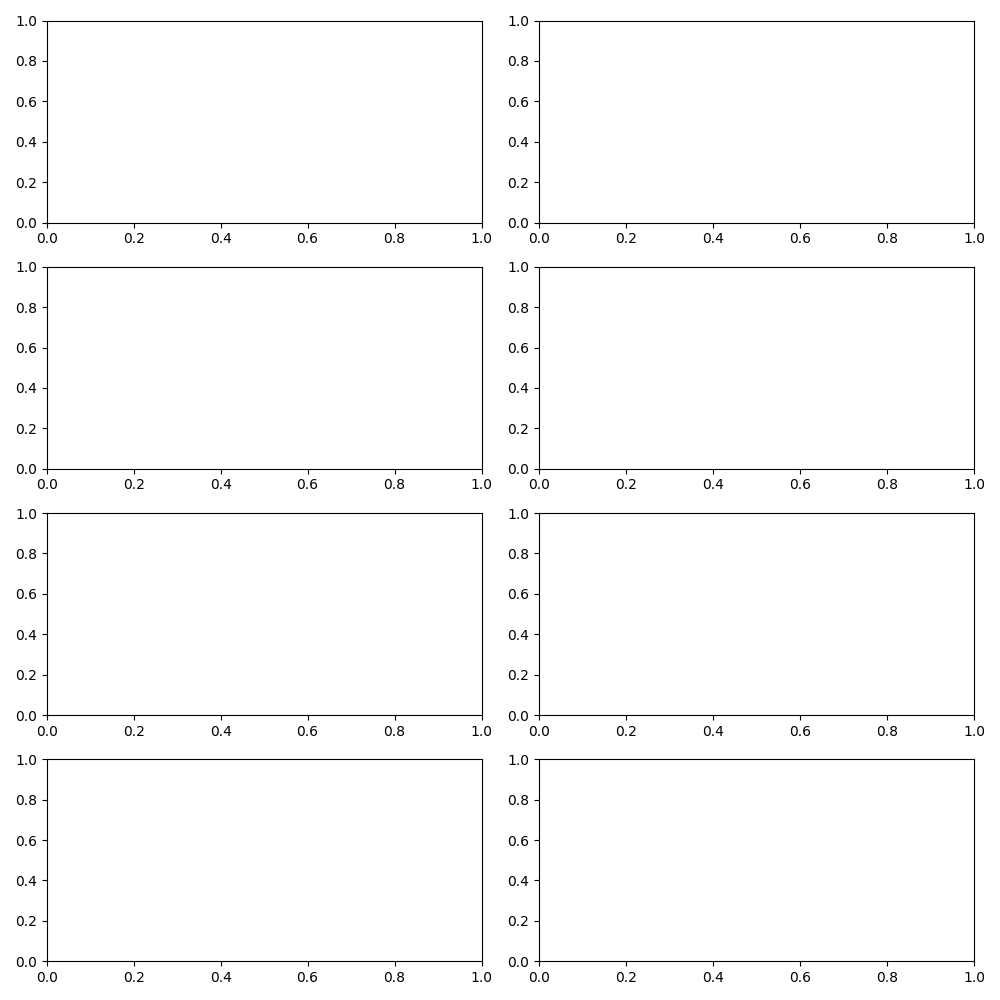

In [12]:
master_bias = CCDData.read(dir + masterbias, unit = u.adu)
master_dark = CCDData.read(dir + masterdark, unit = u.adu)
master_flat = CCDData.read(dir + masterflat, unit = u.adu)
science_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), sciences)]
ppr_science_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), 'ppr-' + sciences)]
one_science = CCDData.read(science_files[0], unit = u.adu)
one_science_ppr = CCDData.read(ppr_science_files[0], unit = u.adu)
master_science = CCDData.read(dir + 'ppr-' + sciencedata, unit = u.adu)
master_science_cosmic = CCDData.read(dir + 'final-' + sciencedata, unit = u.adu)
master_calib = CCDData.read(dir + mastercalib, unit = u.adu)

### prepare canvas for 4x2 images 
colormap = plt.cm.magma
cuts = (5, 98.0)
#fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(12, 12))
#plt.subplots_adjust(wspace=0.1,hspace=0.1,left=0.1,top=0.9,right=0.9,bottom=0.1)
fig, ax = plt.subplots(4, 2, figsize=(10, 10))
plt.tight_layout()
fig.canvas.toolbar_position = 'bottom'

"""
### display images set
imgs_to_display = [master_bias, master_dark, master_flat, master_calib,
                   one_science, one_science_ppr, master_science, master_science_cosmic]
name_to_display = [masterbias, masterdark, masterflat, mastercalib, 
                   sciencedata + '(raw)', sciencedata + '(ppr)', sciencedata + '(ppr+sum)', sciencedata + '(cosmics removed)']
for i, img, name in zip(range(len(imgs_to_display)), imgs_to_display, name_to_display):
    im = ax[int(i/2), int(i%2)].imshow(img, origin='lower', aspect='auto', cmap=colormap)
    cb = plt.colorbar(im)
    ax[int(i/2), int(i%2)].xaxis.set_visible(False)
    ax[int(i/2), int(i%2)].yaxis.set_visible(False)
    ax[int(i/2), int(i%2)].set_title(name)
    im.set_clim(np.percentile(img, cuts))

im_ = plt.imshow(master_science_cosmic.data , origin='lower', aspect='auto', cmap=colormap)
im_.set_clim(np.percentile(master_science_cosmic.data, cuts))
"""


## Create spectra 

### Extract science spectra

In [13]:
### run if spectra free of cosmics is to be used 
#master_science = sci_cleaned.data

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:57 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-02-24 17:14:57 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57667.788056 from DATE-OBS'.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:57 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:14:57 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-02-24 17:14:57 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57667.783970 from DATE-OBS'.


2024-02-24 17:14:58 [WARNING] - Model is linear in parameters; consider using linear fitting methods.


Text(87.72222222222221, 0.5, 'ADU')

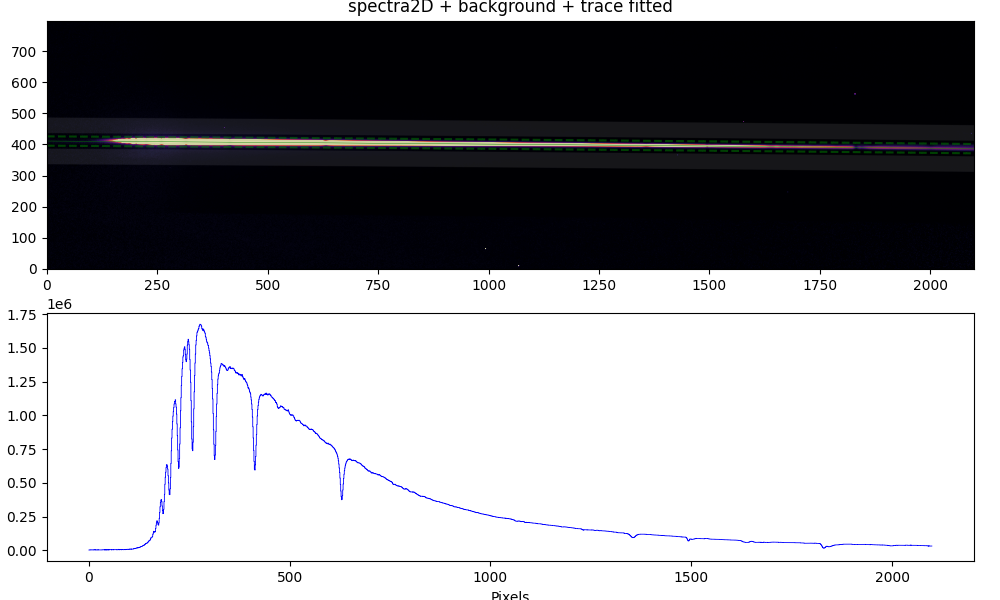

In [14]:
from astropy.modeling import models
from specreduce import tracing, background, extract
import gc

master_science = CCDData.read(dir + 'ppr-' + sciencedata, unit = u.adu)
master_science_cosmic = CCDData.read(dir + 'final-' + sciencedata, unit = u.adu)
master_calib = CCDData.read(dir + mastercalib, unit = u.adu)

#sci_tr = tracing.FlatTrace(master_science, 407)
sci_tr = tracing.FitTrace(master_science,  bins = 64, trace_model=models.Polynomial1D(degree=2), peak_method = 'gaussian') #, window = 50, guess=407)
#trace_model : one of Chebyshev1D, Legendre1D, Polynomial1D, or Spline1D
#peak_method : One of gaussian, centroid, or max. gaussian
bg = background.Background.two_sided(master_science, sci_tr, separation=50, width=50) 
extract = extract.BoxcarExtract(master_science - bg, sci_tr, width = 15)
sci_spectrum = extract()

cuts = (5, 99.0)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
plt.tight_layout()

im = ax0.imshow(master_science, origin='lower', aspect='auto', cmap=plt.cm.magma)
ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
im.set_clim(np.percentile(master_science, cuts))
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace , color='g', linewidth = '0.3')
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.set_title('spectra2D + background + trace fitted')

ax1.step(sci_spectrum.spectral_axis , sci_spectrum.flux, color='b', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')


### Extract calibration spectra

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-02-24 17:15:00 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


(0.0, 100000.0)

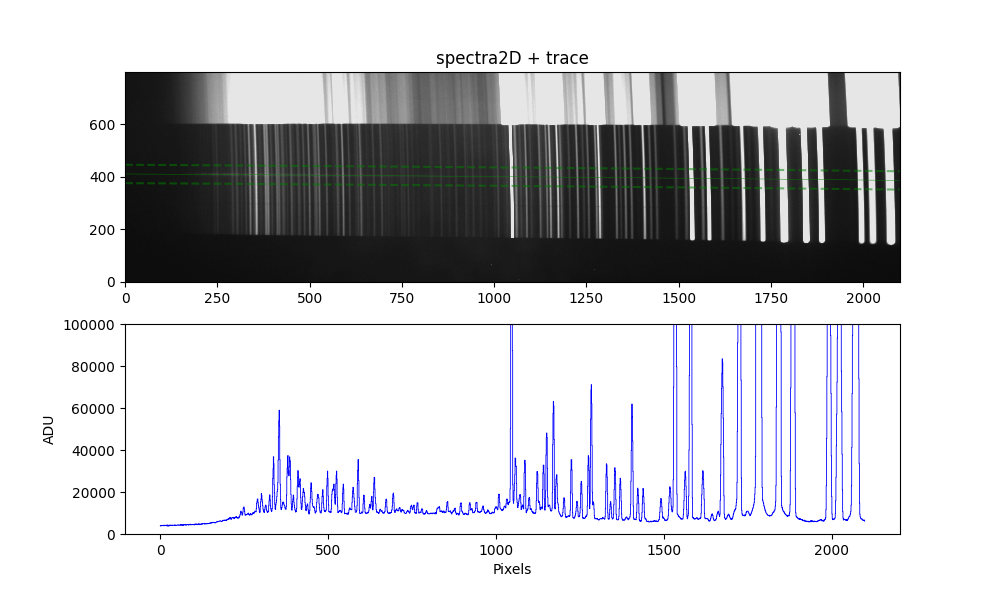

In [15]:
from astropy.modeling import models
from specreduce import tracing, background, extract

neon_data = CCDData.read(dir + mastercalib, unit = u.adu)

#specreduce.tracing.ArrayTrace(image: NDData, trace: ndarray)
#neon_tr = tracing.FlatTrace(neon_data,sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#neon_tr = tracing.ArrayTrace(neon_data, sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#bg = background.Background.two_sided(neon_data, sci_tr, separation=50, width=0) 
extract = extract.BoxcarExtract(neon_data , sci_tr, width = 35)
neon_spectrum = extract()

cuts = (5, 98.0)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
#plt.tight_layout()

im = ax0.imshow(neon_data, origin='lower', aspect='auto', cmap=plt.cm.grey)
#ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
im.set_clim(np.percentile(master_science, cuts))
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace , color='g', linewidth = '0.3')
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.set_title('spectra2D + trace')

ax1.step(neon_spectrum.spectral_axis , neon_spectrum.flux, color='b', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')
ax1.set_ylim(0, 0.1e6)


### Calibrate spectra

residuals : [ 0.0107691  -0.08362146 -0.35696824  0.73221591 -0.03523106 -0.32626165
 -0.01815218  0.07724959] Angstrom
fitted model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
            c0                c1                   c2                    c3         
         Angstrom       Angstrom / pix      Angstrom / pix2       Angstrom / pix3   
    ----------------- ------------------ --------------------- ---------------------
    3309.941118932794 2.5496765078573973 -0.000115880693468754 4.175698872574367e-09


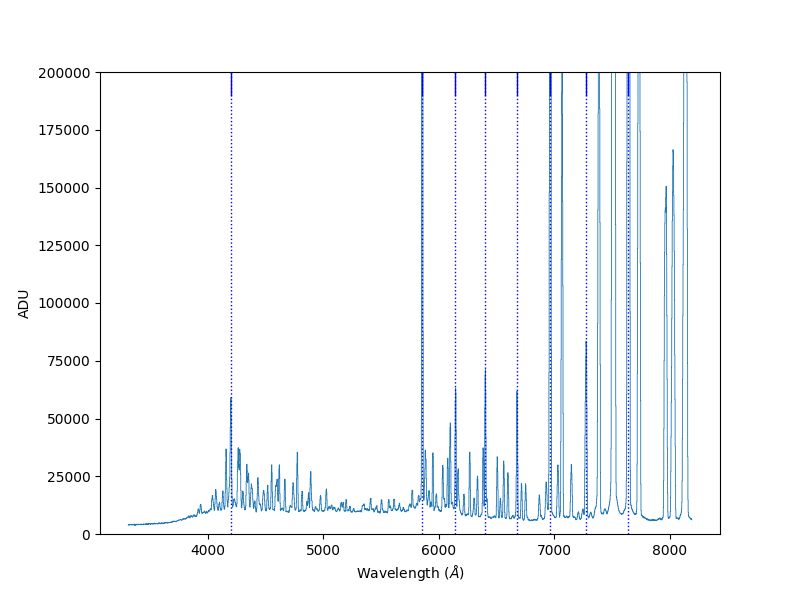

In [16]:
import astropy.units as u
from astropy.modeling import models, fitting
from specreduce import WavelengthCalibration1D

### alpy-600
#pixels = [351, 589, 1045, 1403, 1885, 2073]*u.pix
#wavelength = [4200.67, 4764.87, 5852.49, 6677.28, 7272.94, 7635.11]*u.AA
pixels =     [355,     1045,    1171     , 1284,   1406,      1535  , 1674  , 1840 ]*u.pix
wavelength = [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]*u.AA
wavelength_ = [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]

### StarEx-2400
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

### DADOS-200
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

#line_list = QTable([pixels, wavelength], names=["pixel_center", "wavelength"])
#input_spectrum, matched_line_list=None, line_pixels=None, line_wavelengths=None, catalog=None, input_model=Linear1D(), fitter=None
cal = WavelengthCalibration1D(input_spectrum = neon_spectrum,
      #matched_line_list = line_list,
      line_wavelengths = wavelength,
      line_pixels = pixels,
      input_model = models.Polynomial1D(degree = 3),
      #fitter = fitting.LMLSQFitter()
     )
print('residuals :', cal.residuals )
print('fitted model', cal.fitted_model )
neon_calibrated_spectrum = cal.apply_to_spectrum(neon_spectrum)

plt.figure(figsize=(8,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.step(neon_calibrated_spectrum.spectral_axis, neon_calibrated_spectrum.flux, linewidth = '0.6')  
for line in wavelength_:
    plt.axvline(line, 0.95, 1.0, color = 'b', lw = 1.0)
    plt.axvline(line, color = 'b', lw = 1.0, linestyle = ':')
plt.ylim(0, 0.2e6);


### Apply to science spectra

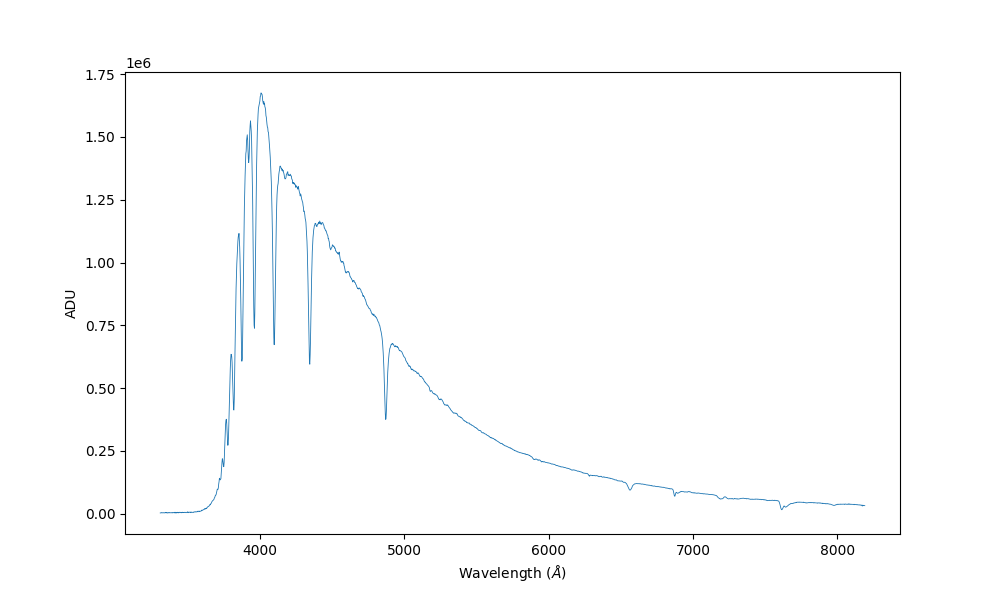

In [17]:
sci_calibrated_spectrum = cal.apply_to_spectrum(sci_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.plot(sci_calibrated_spectrum.wavelength, sci_calibrated_spectrum.flux, linewidth = '0.6');


### Correct atmosphere response

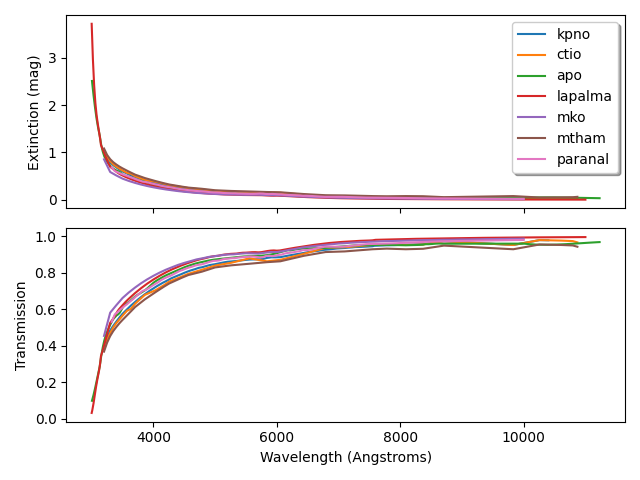

In [18]:
import matplotlib.pyplot as plt
from specreduce.calibration_data import AtmosphericExtinction, SUPPORTED_EXTINCTION_MODELS
from specreduce.fluxcal import FluxCalibration as fc


#print(SUPPORTED_EXTINCTION_MODELS)
#'kpno', 'ctio', 'apo', 'lapalma', 'mko', 'mtham', 'paranal'
#ext = AtmosphericExtinction(model='lapalma', cache=False, show_progress=True)

fig, ax = plt.subplots(2, 1, sharex=True)
for model in SUPPORTED_EXTINCTION_MODELS:
    ext = AtmosphericExtinction(model=model)
    ax[0].plot(ext.spectral_axis, ext.extinction_mag, label=model)
    ax[1].plot(ext.spectral_axis, ext.transmission)
ax[0].legend(fancybox=True, shadow=True)
ax[1].set_xlabel("Wavelength (Angstroms)")
ax[0].set_ylabel("Extinction (mag)")
ax[1].set_ylabel("Transmission")
plt.tight_layout()
#fig.show()


### Correct instrument response 

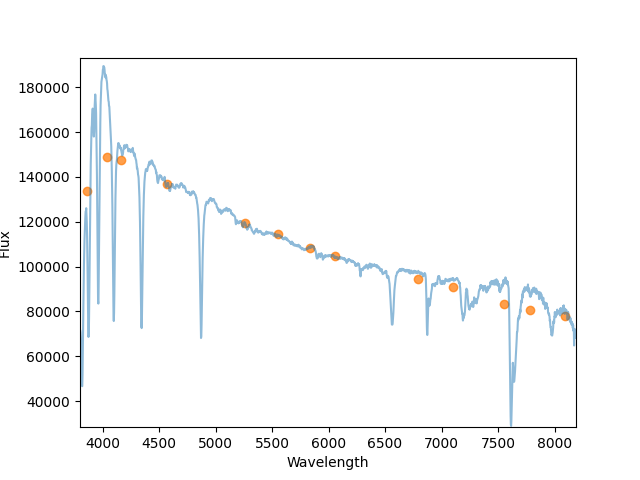

Unit("mJy")

In [19]:
import matplotlib.pyplot as plt
from specreduce.calibration_data import load_MAST_calspec, load_onedstds
from specutils import Spectrum1D
from astropy.nddata import StdDevUncertainty
from specreduce.fluxcal import FluxCalibration
#import specreduce.fluxcal

from astropy.coordinates import SpectralCoord, SkyCoord
from astropy import units as u
from astropy.wcs import WCS

#from specreduce.fluxcal import standard_sensfunc, apply_sensfunc, onedstd, obs_extinction, airmass_cor

#spec = load_MAST_calspec("ltt9491_002.fits")
#spec = load_onedstds("eso", "wdstan/ltt9491_002.dat")
#spec = load_onedstds("eso", "wdstan/ltt9491_002.dat")
#spec = load_onedstds("spec50cal", "bd284211.dat")
#spec = load_MAST_calspec("specreduce_data/reference_data/onedstds/spec50cal/hd217086.dat")
#std_spec = load_onedstds(dataset = 'spec50cal', specfile = 'hd217086.dat')
std_spec = load_onedstds(dataset = 'bstdscal', specfile = 'hr5511.dat')

#load_onedstds(dataset="snfactory", specfile="EG131.dat", cache=True, show_progress=False):
#std_spec = load_MAST_calspec("delumi_stis_004.fits")

std_slice = std_spec[3800*u.AA:8200*u.AA]
sci_slice = sci_calibrated_spectrum[3800*u.AA:8200*u.AA]

"""
fig, ax = plt.subplots()
ax.step(std_slice.spectral_axis, std_slice.flux, where="mid")
ax.step(sci_slice.spectral_axis, sci_slice.flux, where="mid")
ax.set_yscale('log')
ax.set_xlabel(f"Wavelength ({std_slice.spectral_axis.unit})")
ax.set_ylabel(f"Flux ({std_slice.flux.unit})");
#ax.set_xlim(3500, 8600)
#fig.show()
"""

Xfile = fc.obs_extinction('apoextinct.dat')
#print(Xfile)

# Get the airmass from the Headers
#ZD = master_science.header['ZD'] / 180.0 * np.pi
ZD = 21.0
sci_airmass = 1.0/np.cos(ZD) # approximate Zenith Distance -> Airmass conversion

#ZD = master_science.header['ZD'] / 180.0 * np.pi
cal_airmass = 1.0/np.cos(ZD)

obj_spectrum = Spectrum1D(spectral_axis=sci_slice.spectral_axis, flux=sci_slice.flux)

sci_spectrum = FluxCalibration(obj_spectrum) #, airmass=1.00, zeropoint=48.60)

sci_fitX = sci_spectrum.airmass_cor(Xfile)

responsefunc = sci_spectrum.standard_sensfunc(standard = std_slice, mode='linear', polydeg=5, display=True)

final_spec = sci_spectrum.apply_sensfunc(responsefunc)

#plt.plot(final_spec.wavelength, final_spec.flux, c='k')
#plt.xlabel('Wavelength ['+str(final_spec.wavelength.unit)+']')
#plt.ylabel('Flux ['+str(final_spec.flux.unit)+']')
    
final_spec.flux.unit

## Analyse spectra

### Identify lines

In [20]:
def add_lines(z, ax = None, rest_frame = True, em_label = True, abs_label = True, em_lines = None, abs_lines = None):
    """
    Function to add emission and/or absorption lines onto a plot. 
    
    If em_lines or abs_lines is given, plotting only the specified lines.
    If no lines are given, plotting all the lines that are present in x-range of the plot.
    
    Parameters
    ----------
    z : float
        Redshift value of the source
    
    ax : AxesSubplot
        The axis onto which the emission/absoption lines needs to be plotted.
        If ax = None, then the plotting function uses plt, rather than axis.
        
    rest_frame : bool
        Whether or not the plot is in rest-frame. Default is True.
    
    em_label : bool
        Whether or not to label the emission lines. Default is True.
        
    abs_label : bool
        Whether or not to label the absorption lines. Default is True.
    
    em_lines : list
        List of emission lines to label
    
    abs_lines : list
        List of absorption lines to label
    
    Returns
    -------
    None
    
    """
    
    # List of lines
    # This is the set of emission lines from the spZline files. 
    # All the wavelengths are in vaccuum wavelengths.

    # Emission Lines
    emission_lines = [
    {"name" : "Ly-alpha",       "lambda" : 1215.67,  "emission": True,  "label" : "Ly$\\alpha$"},
    {"name" : "N V 1240",       "lambda" : 1240.81,  "emission": True,  "label" : "N V"},
    {"name" : "C IV 1549",      "lambda" : 1549.48,  "emission": True,  "label" : "C IV" },
    {"name" : "He II 1640",     "lambda" : 1640.42,  "emission": True,  "label" : "He II"},
    {"name" : "C III] 1908",    "lambda" : 1908.734, "emission": True,  "label" : "C III]"},
    {"name" : "Mg II 2799",     "lambda" : 2800.315, "emission": True,  "label" : "Mg II" },
    {"name" : "[O II] 3725",    "lambda" : 3727.092, "emission": True,  "label" : " "},
    {"name" : "[O II] 3727",    "lambda" : 3729.875, "emission": True,  "label" : "[O II]"}, 
    {"name" : "[Ne III] 3868",  "lambda" : 3869.857, "emission": True,  "label" : "[Ne III]"},
    {"name" : "H-zeta",         "lambda" : 3890.151, "emission": True,  "label" : "H$\\zeta$"},
    {"name" : "[Ne III] 3970",  "lambda" : 3971.123, "emission": True,  "label" : "[Ne III]"},
    {"name" : "H-epsilon",      "lambda" : 3971.195, "emission": True,  "label" : "H$\\epsilon$"}, 
    {"name" : "H-delta",        "lambda" : 4102.892, "emission": True,  "label" : "H$\\delta$"},
    {"name" : "H-gamma",        "lambda" : 4341.684, "emission": True,  "label" : "H$\\gamma$"},
    {"name" : "[O III] 4363",   "lambda" : 4364.435, "emission": True,  "label" : "[O III]"},
    {"name" : "He II 4685",     "lambda" : 4686.991, "emission": True,  "label" : "He II"},
    {"name" : "H-beta",         "lambda" : 4862.683, "emission": True,  "label" : "H$\\beta$"},
    {"name" : "[O III] 4959",   "lambda" : 4960.294, "emission": True,  "label" : "[O III]" },
    {"name" : "[O III] 5007",   "lambda" : 5008.239, "emission": True,  "label" : "[O III]" },
    {"name" : "He II 5411",     "lambda" : 5413.025, "emission": True,  "label" : "He II"},
    {"name" : "[O I] 5577",     "lambda" : 5578.888, "emission": True,  "label" : "[O I]" },
    {"name" : "[N II] 5755",    "lambda" : 5756.186, "emission": True,  "label" : "[Ne II]" },
    {"name" : "He I 5876",      "lambda" : 5877.308, "emission": True,  "label" : "He I" },
    {"name" : "[O I] 6300",     "lambda" : 6302.046, "emission": True,  "label" : "[O I]" },
    {"name" : "[S III] 6312",   "lambda" : 6313.806, "emission": True,  "label" : "[S III]" },
    {"name" : "[O I] 6363",     "lambda" : 6365.535, "emission": True,  "label" : "[O I]" },
    {"name" : "[N II] 6548",    "lambda" : 6549.859, "emission": True,  "label" : "[N II]" },
    {"name" : "H-alpha",        "lambda" : 6564.614, "emission": True,  "label" : "H$\\alpha$" },
    {"name" : "[N II] 6583",    "lambda" : 6585.268, "emission": True,  "label" : "[N II]" },
    {"name" : "[S II] 6716",    "lambda" : 6718.294, "emission": True,  "label" : "[S II]" },
    {"name" : "[S II] 6730",    "lambda" : 6732.678, "emission": True,  "label" : "[S II]" },
    {"name" : "[Ar III] 7135",  "lambda" : 7137.758, "emission": True,  "label" : "[Ar III]" },]


    # Absorption lines
    absorption_lines = [
#    {"name" : "H12",            "lambda" : 3751.22,  "emission": False, "label" : "H12"},
#    {"name" : "H11",            "lambda" : 3771.70,  "emission": False, "label" : "H11"},
#    {"name" : "H10",            "lambda" : 3798.98,  "emission": False, "label" : "H10"},
#    {"name" : "H9",             "lambda" : 3836.48,  "emission": False, "label" : "H9"},
    {"name" : "H-zeta",         "lambda" : 3890.151, "emission": False, "label" : "H$\\zeta$" },
    {"name" : "K (Ca II 3933)", "lambda" : 3934.814, "emission": False, "label" : "K (Ca II)"},
    {"name" : "H (Ca II 3968)", "lambda" : 3969.623, "emission": False, "label" : "H (Ca II)"},
    {"name" : "H-epsilon",      "lambda" : 3971.195, "emission": False, "label" : "H$\\epsilon$"}, 
    {"name" : "H-delta",        "lambda" : 4102.892, "emission": False, "label" : "H$\\delta$" },
    {"name" : "G (Ca I 4307)",  "lambda" : 4308.952, "emission": False, "label" : "G (Ca I)"},
    {"name" : "H-gamma",        "lambda" : 4341.684, "emission": False, "label" : "H$\\gamma$"},
    {"name" : "H-beta",         "lambda" : 4862.683, "emission": False, "label" : "H$\\beta$"},
#    {"name" : "Mg I 5175",      "lambda" : 5176.441, "emission": False, "label" : "Mg I"},  #Triplet
    {"name" : "Mg I 5183",      "lambda" : 5185.048, "emission": False, "label" : " "},
    {"name" : "Mg I 5172",      "lambda" : 5174.125, "emission": False, "label" : " "},
    {"name" : "Mg I 5167",      "lambda" : 5168.762, "emission": False, "label" : "Mg I"},
    {"name" : "D2 (Na I 5889)", "lambda" : 5891.582, "emission": False, "label" : " " },
    {"name" : "D1 (Na I 5895)", "lambda" : 5897.554, "emission": False, "label" : "D1,2 (Na I)" },
    {"name" : "H-alpha",        "lambda" : 6564.614, "emission": False, "label" : "H$\\alpha$"},
    {"name" : "B (atm O2 6867-6944)", "lambda" : 6867.0, "emission": False, "label" : "atm (O2)"},
    {"name" : "H2O (atm 7168-7394)", "lambda" : 7168.0, "emission": False, "label" : "atm (H2O)"},
    {"name" : "A (atm O2 7594-7684)", "lambda" : 7584.0, "emission": False, "label" : "atm (O2)"},
    ]
    
    if (ax == None):
        # If there is no axes given, plotting with the plt function
        ax = plt.gca()
    
    if (em_lines != None):
        # Choosing the emission lines listed by the user
        emission_lines = list(filter(lambda x: x['name'] in em_lines, emission_lines))
    
    if (abs_lines != None):
        # Choosing the absorption lines listed by the user
        absorption_lines = list(filter(lambda x: x['name'] in abs_lines, absorption_lines)) 
    
    xbounds = ax.get_xbound()   # Getting the x-range of the plot 
    # This is for selecting only those lines that are visible in the x-range of the plot
    
    for ii in range(len(emission_lines)):
        # If rest_frame = False, redshifting the emission lines to the observed frame of the source
        if (rest_frame == False):
            lam = emission_lines[ii]['lambda']*(1+z)
        else:
            lam = emission_lines[ii]['lambda']
        # Plotting the emission lines if they are within the x-range of the plot
        if (em_label == True):
            if (emission_lines[ii]['emission']) & (lam > xbounds[0]) & (lam < xbounds[1]):
                ax.axvline(lam, 0.95, 1.0, color = 'b', lw = 1.0)
                ax.axvline(lam, color = 'b', lw = 1.0, linestyle = ':')
                trans = ax.get_xaxis_transform()
                # Labeling the emission lines if em_label = True
                ax.annotate(emission_lines[ii]['label'], xy = (lam, 1.05), xycoords = trans, \
                         fontsize = 8, rotation = 90, color = 'b')
            
    for ii in range(len(absorption_lines)):
        # If rest_frame = False, redshifting the absorption lines to the observed frame of the source
        if (rest_frame == False):
            lam = absorption_lines[ii]['lambda']*(1+z)
        else:
            lam = absorption_lines[ii]['lambda']
        # Plotting the absorption lines if they are within the x-range of the plot
        if (lam > xbounds[0]) & (lam < xbounds[1]):
            ax.axvline(lam, 0.95, 1.0, color = 'r', lw = 1.0)
            ax.axvline(lam, color = 'r', lw = 1.0, linestyle = ':')
#            ax.axvline(lam, 0.2, 1.0, color = 'r', lw = 1.0, linestyle = ':')
            trans = ax.get_xaxis_transform()
            if (abs_label == True):
                # Labeling the absorption lines if abs_label = True
                ax.annotate(absorption_lines[ii]['label'], xy = (lam, 1.01), xycoords = trans, \
                         fontsize = 6, rotation = 90, color = 'r')

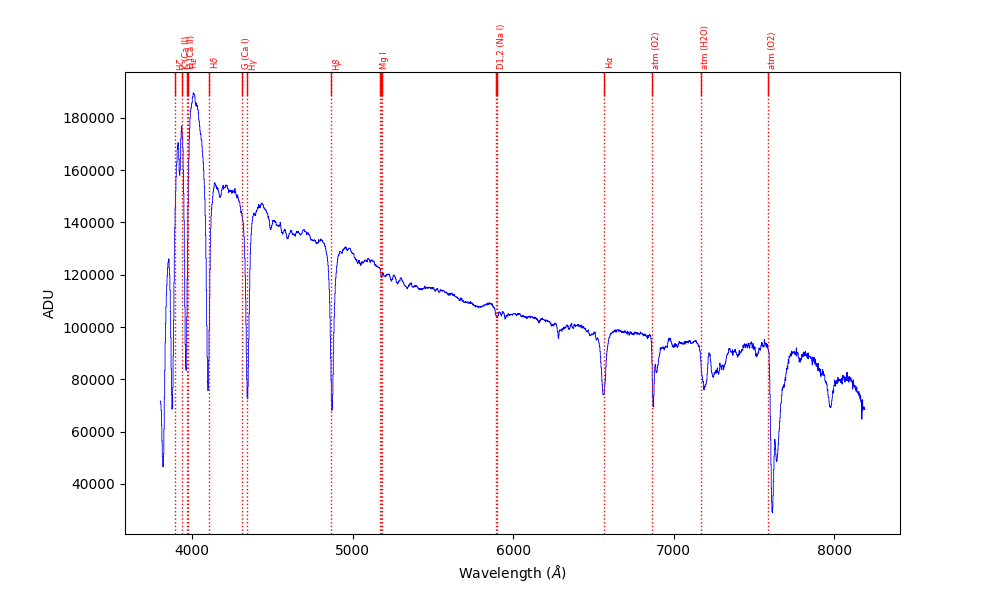

In [28]:
plt.figure(figsize = (10,6))
plt.step(final_spec.wavelength, final_spec.flux, color='b', linewidth = '0.6')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
#plt.ylim(-10000, 1e6)

add_lines(z = 0.0, ax = None, em_label = False, abs_label = True, rest_frame = True) #, em_lines = True , abs_lines = True )

final_spec.write(dir + '1D_final_' + sciencedata)

### Measure R, SNR

In [113]:
from specutils.fitting import fit_generic_continuum, fit_continuum
from specutils import SpectralRegion
from astropy.modeling import models, fitting
from specutils.analysis import snr, snr_derived
from specutils import Spectrum1D
from specutils.spectra import SpectralRegion
from specutils.manipulation import extract_region

final_spec1d = Spectrum1D.read(dir + '1D_final_' + sciencedata)  
snr_derived(final_spec1d)

<Quantity 224.94104979>

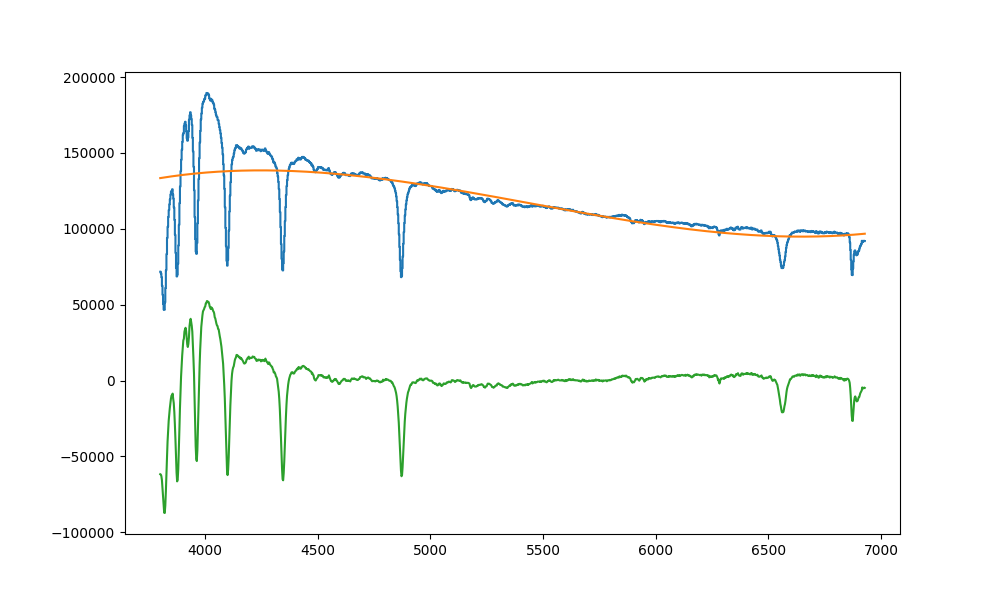

In [137]:
### extract continuum on a selected region

region = SpectralRegion(3800*u.AA, 6930*u.AA)
sub_spectra = extract_region(final_spec1d, region)

generic_continuum = fit_generic_continuum(sub_spectra)
#generic_continuum = fit_continuum(sub_spectra, models.Hermite1D(2))

generic_continuum_evaluated = generic_continuum(sub_spectra.spectral_axis)

cont_spectra = sub_spectra.flux - generic_continuum_evaluated

plt.figure(figsize = (10,6))
plt.step(sub_spectra.spectral_axis, sub_spectra.flux)
plt.plot(sub_spectra.spectral_axis, generic_continuum_evaluated)
plt.plot(sub_spectra.spectral_axis, cont_spectra)



Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean            stddev     
           mJy             Angstrom         Angstrom    
    ------------------ --------------- -----------------
    133644.62278698623 4874.6332283966 45.02459673160765
2024-02-24 20:58:09 [WARNING] - The fit may be unsuccessful; check fit_info['message'] for more information.
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
           mJy              Angstrom           Angstrom    
    ----------------- ------------------- -----------------
    858494.6529204751 -24094.795150299266 14562.73179871974


"\ncontinuum_fitted = continuum(final_spec.spectral_axis)\n\nspectra_sub = final_spec - continuum_fitted\nspectra_norm = final_spec / continuum_fitted\n\nax0, ax1, ax2 = plt.subplots(3, 1, figsize = (10,10))[1]\n#plt.tight_layout()\nplt.toolbar_position = 'bottom'\n\nax0.step(final_spec.spectral_axis, final_spec.flux)\nax0.plot(continuum_fitted.spectral_axis, continuum_fitted)\nax0.set_title('original spectra and fit curve')\n\nax1.step(spectra_sub.wavelength, spectra_sub.flux)\n#ax1.set_ylim(-500, 5000000)\nax1.axhline(0, color='k', ls=':')  # continuum should be at flux=0\nax1.set_title('spectra sub by continuum')\n\nax2.step(spectra_norm.wavelength, spectra_norm.flux)\n#ax2.set_ylim(-20, 50)\nax2.axhline(1, color='k', ls='--');  # continuum should be at flux=1\nax2.set_title('spectra div by continuum');\n"

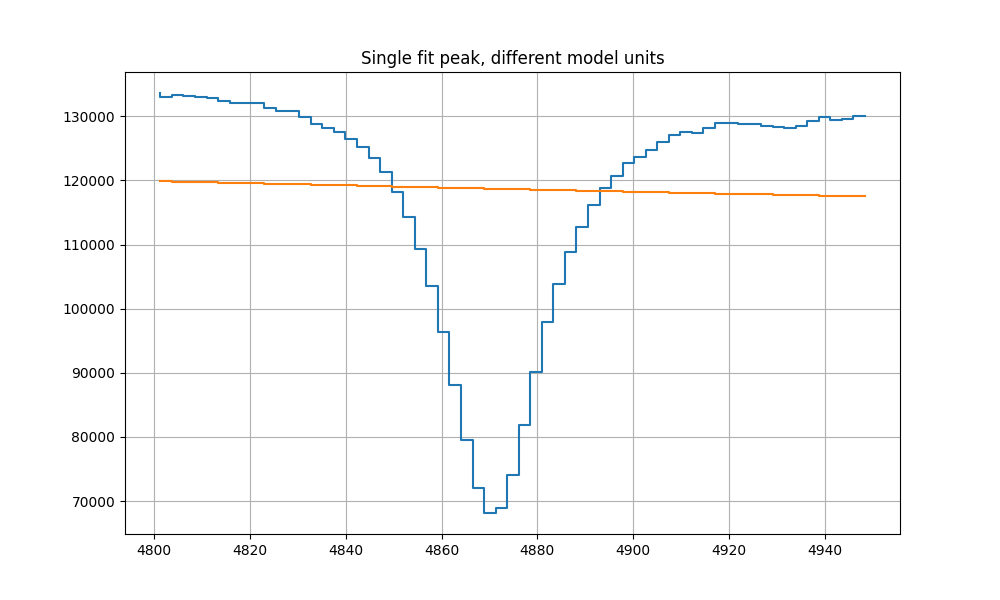

In [186]:
from specutils.fitting import fit_generic_continuum, fit_continuum
from astropy import units as u
from specutils import SpectralRegion
from astropy.modeling import models, fitting
from specutils.fitting import fit_lines
from specutils.analysis import line_flux, centroid, gaussian_sigma_width, gaussian_fwhm, fwhm, fwzi
from specutils.fitting import estimate_line_parameters

region_to_measure = SpectralRegion(4800*u.AA, 4950*u.AA)
reg_spectra = extract_region(final_spec1d, region_to_measure)

print(estimate_line_parameters(reg_spectra, models.Gaussian1D()))  

line_estimate = models.Gaussian1D(amplitude=133644*u.mJy, mean=4873*u.AA, stddev=45*u.AA)
line_model = fit_lines(reg_spectra, line_estimate)
evaluated_model = line_model(reg_spectra.wavelength)

print(line_model)

plt.figure(figsize = (10,6))
plt.step(reg_spectra.wavelength, reg_spectra.flux, label="Original spectrum")
plt.step(reg_spectra.wavelength, evaluated_model, label="Fit result")
plt.title('Single fit peak, different model units')
plt.grid(True)
#plt.show

"""
continuum_fitted = continuum(final_spec.spectral_axis)

spectra_sub = final_spec - continuum_fitted
spectra_norm = final_spec / continuum_fitted

ax0, ax1, ax2 = plt.subplots(3, 1, figsize = (10,10))[1]
#plt.tight_layout()
plt.toolbar_position = 'bottom'

ax0.step(final_spec.spectral_axis, final_spec.flux)
ax0.plot(continuum_fitted.spectral_axis, continuum_fitted)
ax0.set_title('original spectra and fit curve')

ax1.step(spectra_sub.wavelength, spectra_sub.flux)
#ax1.set_ylim(-500, 5000000)
ax1.axhline(0, color='k', ls=':')  # continuum should be at flux=0
ax1.set_title('spectra sub by continuum')

ax2.step(spectra_norm.wavelength, spectra_norm.flux)
#ax2.set_ylim(-20, 50)
ax2.axhline(1, color='k', ls='--');  # continuum should be at flux=1
ax2.set_title('spectra div by continuum');
"""


Text(0, 0.5, 'ADU')

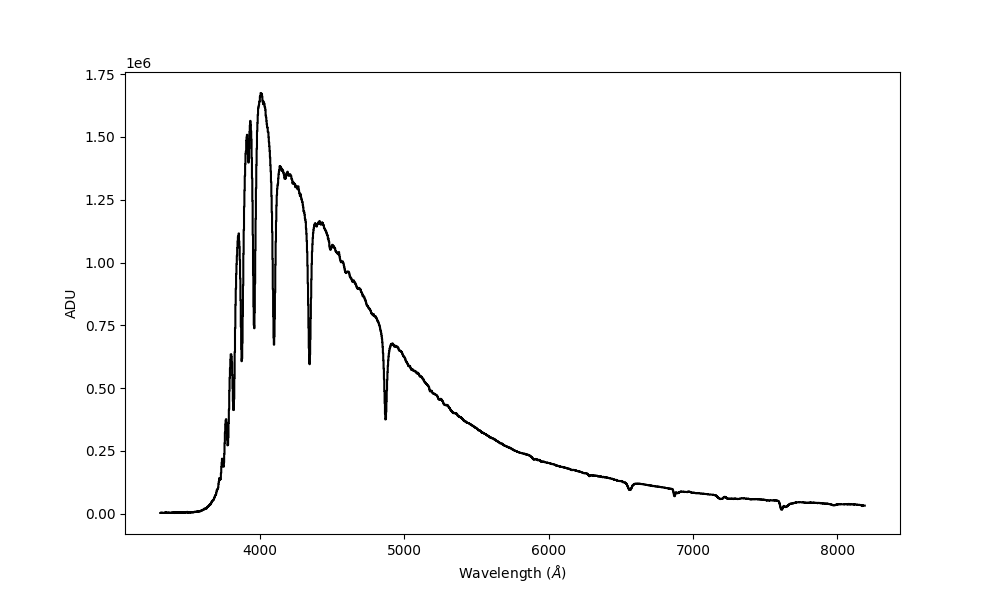

In [61]:
plt.figure(figsize = (10,6))
plt.step(sci_calibrated_spectrum.wavelength, sci_calibrated_spectrum.flux, color='black')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
#plt.ylim(-10000, 1e6)


In [ ]:
from specutils.fitting import fit_generic_continuum, fit_continuum
from specutils import SpectralRegion
from astropy.modeling import models, fitting
from specutils import fitting

halpha_lines = fitting.find_lines_threshold(sdss_gencont_sub, 3)
plt.step(sdss_gencont_sub.spectral_axis, sdss_gencont_sub.flux, where='mid')
#print(halpha_lines['line_center'])

for line in halpha_lines:
    print(line['line_center']*u.pixel)
    plt.axvline(line['line_center']*u.pixel, color='k', ls=':')


### Fit a line

In [ ]:
### select a region 

### remove continuum


### fit line



### Measure FWHM, flux, EW, Area

In [ ]:
### measure 
